In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import RGBDataModule


# dm = RGBDataModule()
dm = RGBDataModule(batch_size=8)
dm.setup()

train: 8689
test: 2773


In [3]:
dl = dm.train_dataloader()
images, labels = next(iter(dl))

images.shape, images.dtype, images.min(), images.max(), labels.shape, labels.dtype, labels.min(), labels.max()

(torch.Size([8, 3, 256, 256]),
 torch.float32,
 tensor(0.),
 tensor(1.),
 torch.Size([8, 256, 256]),
 torch.float32,
 tensor(-0.9979),
 tensor(60.7854))

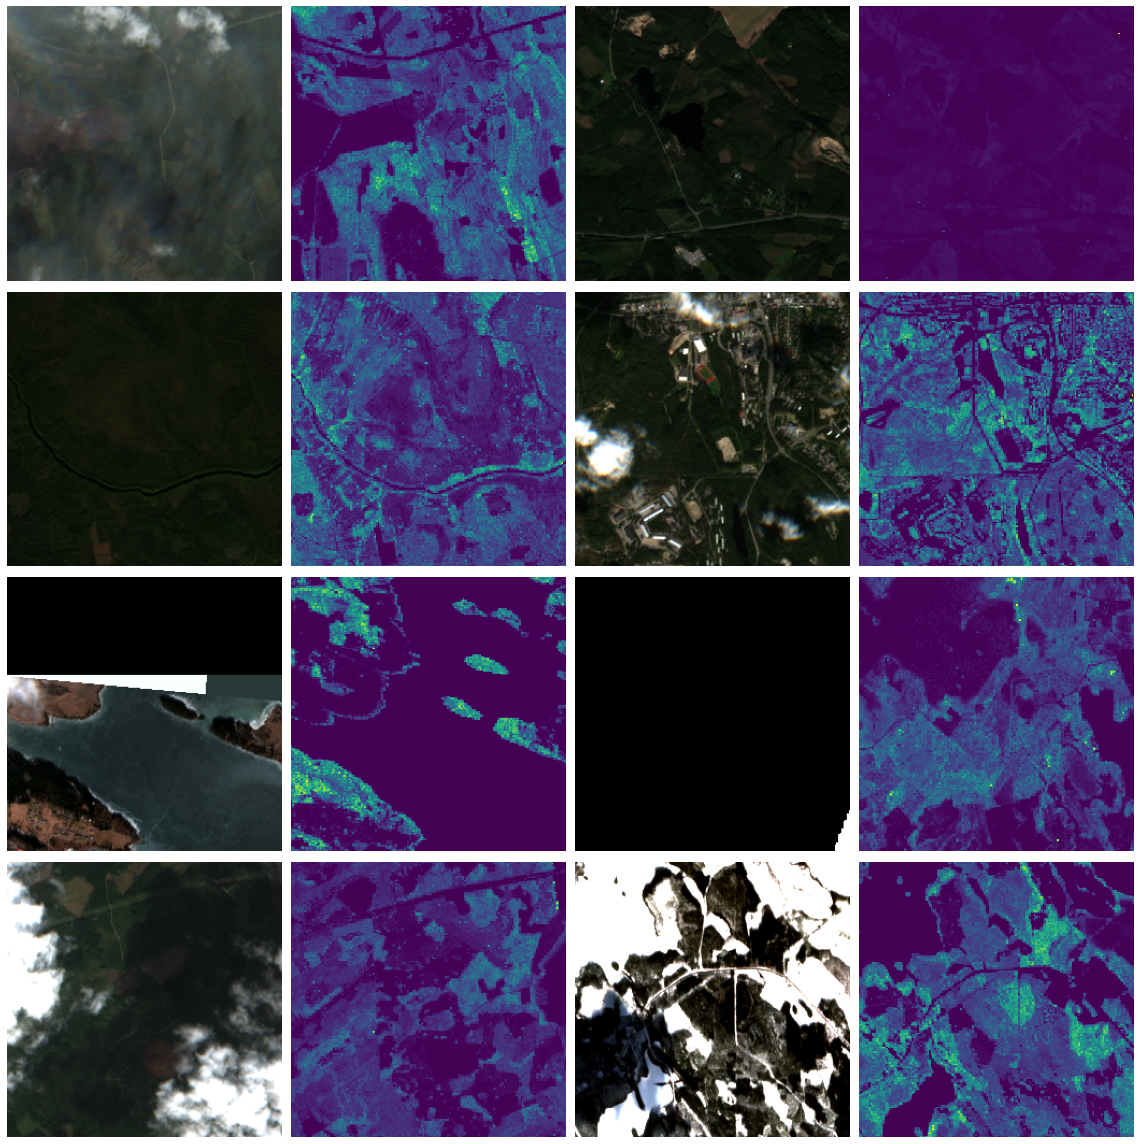

In [4]:
import matplotlib.pyplot as plt 

# plot and 4x4 grid of images
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
dl = dm.train_dataloader()
images, labels = next(iter(dl))
for i in range(4):
	for j in range(2):
		ax[i, j*2].imshow(images[i*2+j].permute(1, 2, 0))
		ax[i, j*2].axis('off')
		ax[i, j*2+1].imshow(labels[i*2+j])
		ax[i, j*2+1].axis('off')
plt.tight_layout()
plt.show()

In [5]:
trans = {
	'HorizontalFlip': {'p': 0.5},
	'VerticalFlip': {'p': 0.5},
	'RandomRotate90': {'p': 0.5},
	'Transpose': {'p': 0.5}
}

dm = RGBDataModule(temporal=False, batch_size=2, train_trans=trans)
dm.setup()

TypeError: __init__() got an unexpected keyword argument 'temporal'

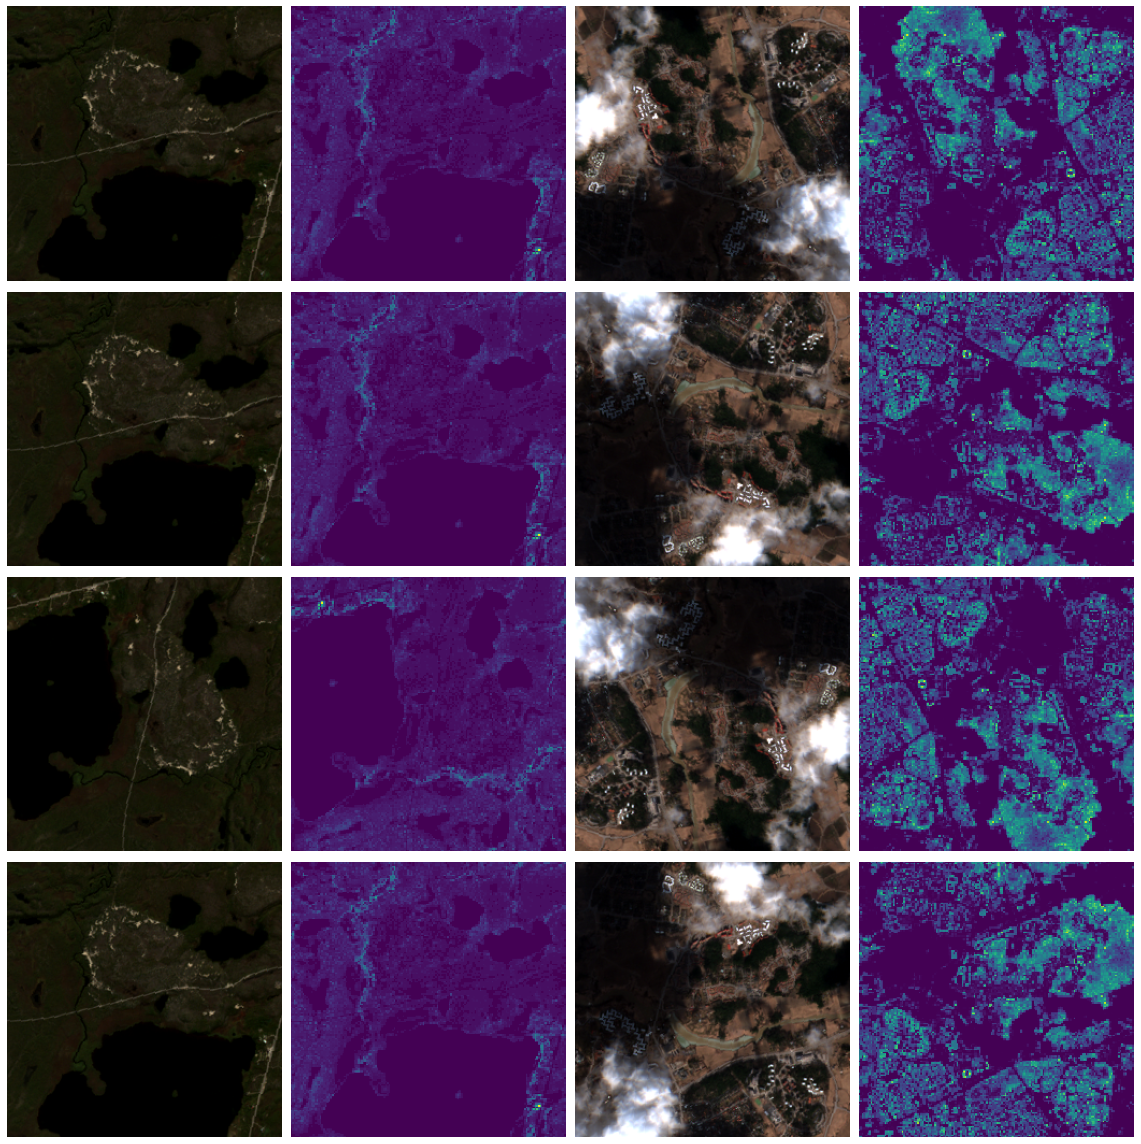

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
	dl = dm.train_dataloader(shuffle=False)
	images, labels = next(iter(dl))
	for j in range(2):
		ax[i, j*2].imshow(images[j].permute(1, 2, 0))
		ax[i, j*2].axis('off')
		ax[i, j*2+1].imshow(labels[j])
		ax[i, j*2+1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
from src.module import RGBModule

hparams = {
	'encoder': 'resnet34',
	'pretrained': "imagenet",
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = RGBModule(hparams)

module.unet

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Overfit batches

In [17]:
import pytorch_lightning as pl
import torch

dm = RGBDataModule(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-2
	},
}


module = RGBModule(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=1000,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type | Params
------------------------------
0 | unet | Unet | 14.3 M
------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
28.656    Total estimated model params size (MB)


train: 8689
test: 2773


Training: 0it [00:00, ?it/s]

In [18]:
dl = dm.train_dataloader(shuffle=False)
images, labels = next(iter(dl))
preds = module.predict(images)

preds.shape, preds.dtype, preds.min(), preds.max()

(torch.Size([4, 256, 256]), torch.float32, tensor(-2.0549), tensor(6.7094))

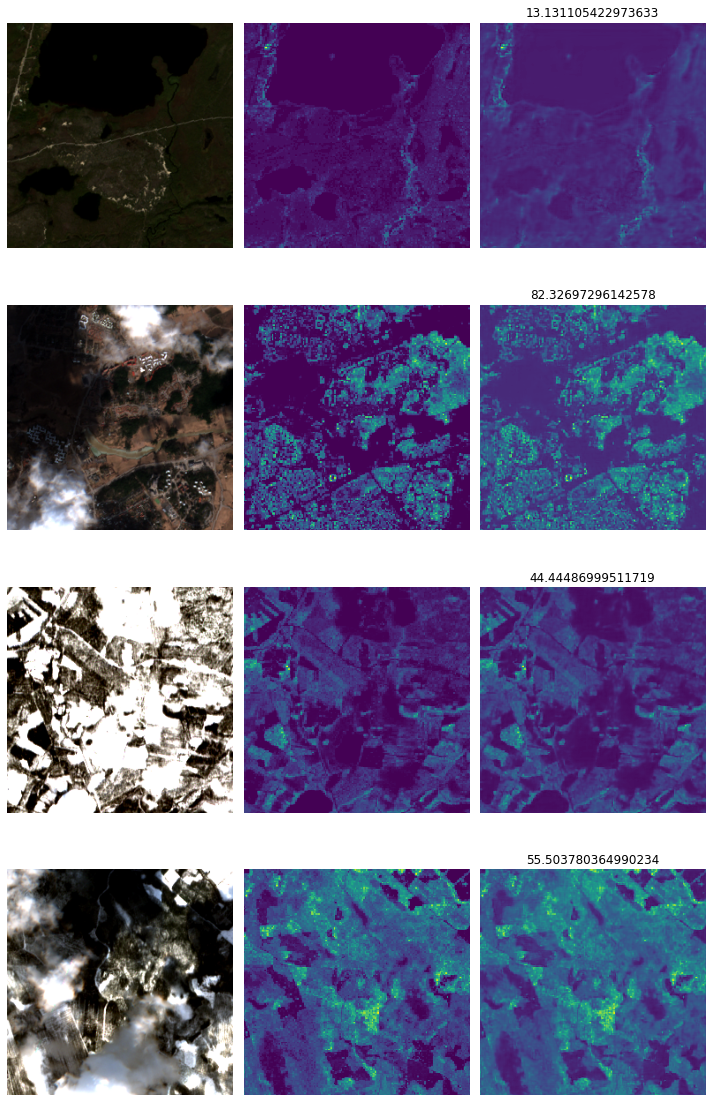

In [19]:
import torch 

fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(images[i].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(labels[i])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
	ax[i, 2].set_title(torch.sqrt(
            torch.sum((preds[i] - labels[i])**2)).item())
plt.tight_layout()
plt.show()